# Plot accumulated pollution results

In [104]:
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from matplotlib.patheffects import withStroke
from matplotlib.pyplot import text

from src.tools.plotter import init_plots, store_sns
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType

init_plots()

In [3]:
xlabels = {
    PollutionType.gauss: "Gaussian noise parameter",
    PollutionType.jitter: "Clock jitter parameter",
    PollutionType.delay: "Random delay parameter"
}

titles = {
    Database.ascad: {
        PollutionType.gauss: "ASCAD (Masked, Gaussian noise)\nPerformance on 300.000 traces"
    },
    Database.ascad_none: {
        PollutionType.gauss: "ASCAD (Unprotected, Gaussian noise)\nPerformance on 30.000 traces",
        PollutionType.jitter: "ASCAD (Unprotected, Clock jitter)",
        PollutionType.delay: "ASCAD (Unprotected, Random delay)"
    },
    Database.aisy: {
        PollutionType.gauss: "AISy LA traces (Unprotected, Gaussian noise)\nPerformance on 2.500 traces",
        PollutionType.jitter: "AISy LA traces (Unprotected, Clock jitter)\nPerformance on 2.500 traces",
        PollutionType.delay: "AISy LA traces (Unprotected, Random delay)\nPerformance on 2.500 traces"
    }
}

In [130]:
DLLA_PALETTE = sns.light_palette(sns.color_palette()[0], n_colors=5)
TVLA_PALETTE = sns.light_palette(sns.color_palette()[1], n_colors=5)

THRESHOLD_COLOR = "#FF000080"

In [123]:
methods = {
    "dlla9": ("DL-LA 9 class", DLLA_PALETTE[3], "-"),
    "dlla2": ("Wegener DL-LA", DLLA_PALETTE[1], "-"),
    "cri_tvla_1": ("CRI TVLA $\mu_1$", TVLA_PALETTE[3], "--"),
    "cri_tvla_2": ("CRI TVLA $\mu_2$", TVLA_PALETTE[1], "--")
}

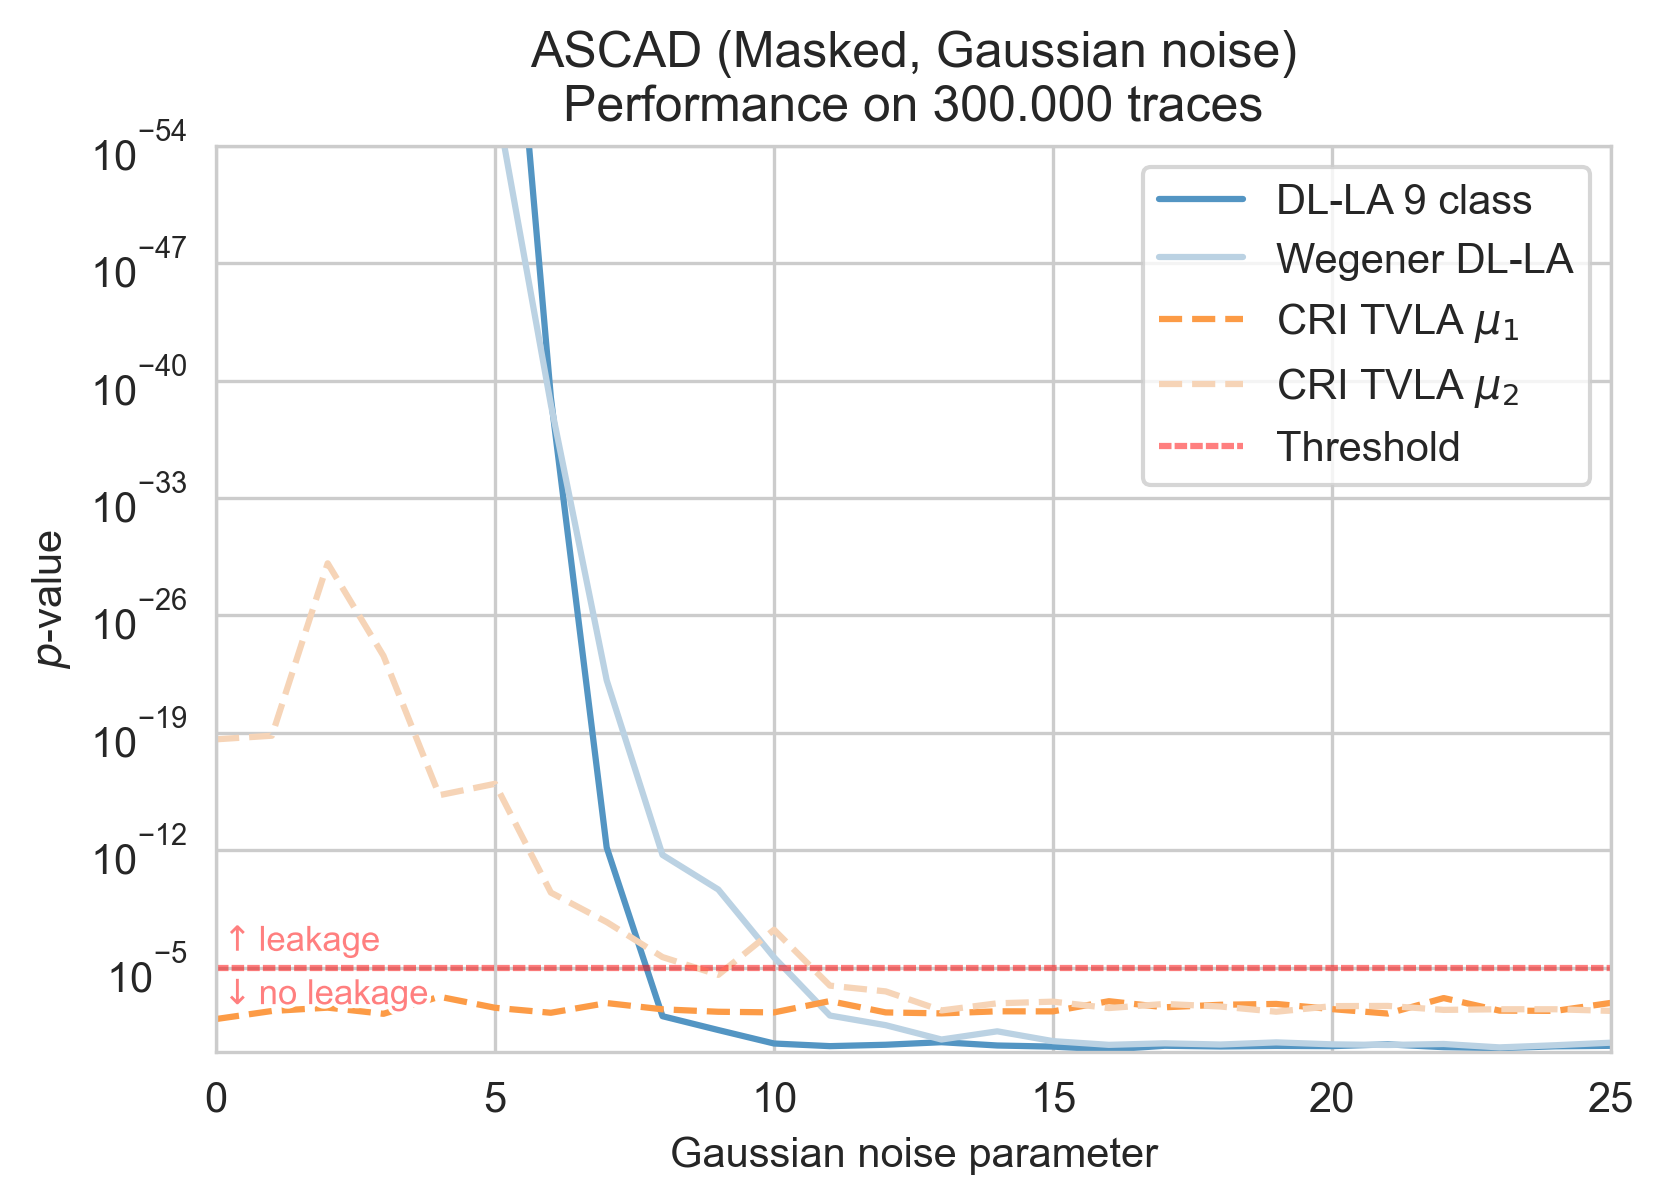

In [145]:
def plot(db: Database, pollution: PollutionType, ylim=(1, 10 ** -256), xlim=(0, 16), num_traces: str = None):
    suffix = ""
    if num_traces is not None:
        suffix = f"_{num_traces}"
    file_name = f"results_{db.name}{suffix}.csv"

    df = pd.read_csv(file_name, sep=";")
    df = df[df.pollution == pollution.name].drop(columns=[df.pollution.name])

    gdf = df.groupby(df.method)

    for method, (label, color, style) in methods.items():
        if method in gdf.groups:
            method_group = gdf.get_group(method)
            med = method_group.groupby(df.param).median()

            sns.lineplot(x=med.param, y=med.p, label=label, color=color, linestyle=style)

    len_axis = xlim[1] + 1

    stroke = [withStroke(linewidth=2, foreground='w')]
    text(0, 10 ** -6, '$\\uparrow$leakage', color=THRESHOLD_COLOR, size="small").set_path_effects(stroke)
    text(0, 10 ** -4.5, '$\\downarrow$no leakage', va='top', color=THRESHOLD_COLOR, size="small").set_path_effects(stroke)

    t_line = [10 ** -5] * len_axis
    g = sns.lineplot(data={"Threshold": t_line}, palette=[THRESHOLD_COLOR], dashes=[(2, .5)])

    g.invert_yaxis()
    g.set(yscale="log",
          ylim=ylim,
          xlim=xlim,
          xlabel=xlabels[pollution],
          ylabel="$p$-value",
          title=titles[db][pollution])

    store_sns(g, f"pollution-results-{db.name}-{pollution.name}")


plot(Database.ascad, PollutionType.gauss, xlim=(0, 25), ylim=(1, 10 ** -54))

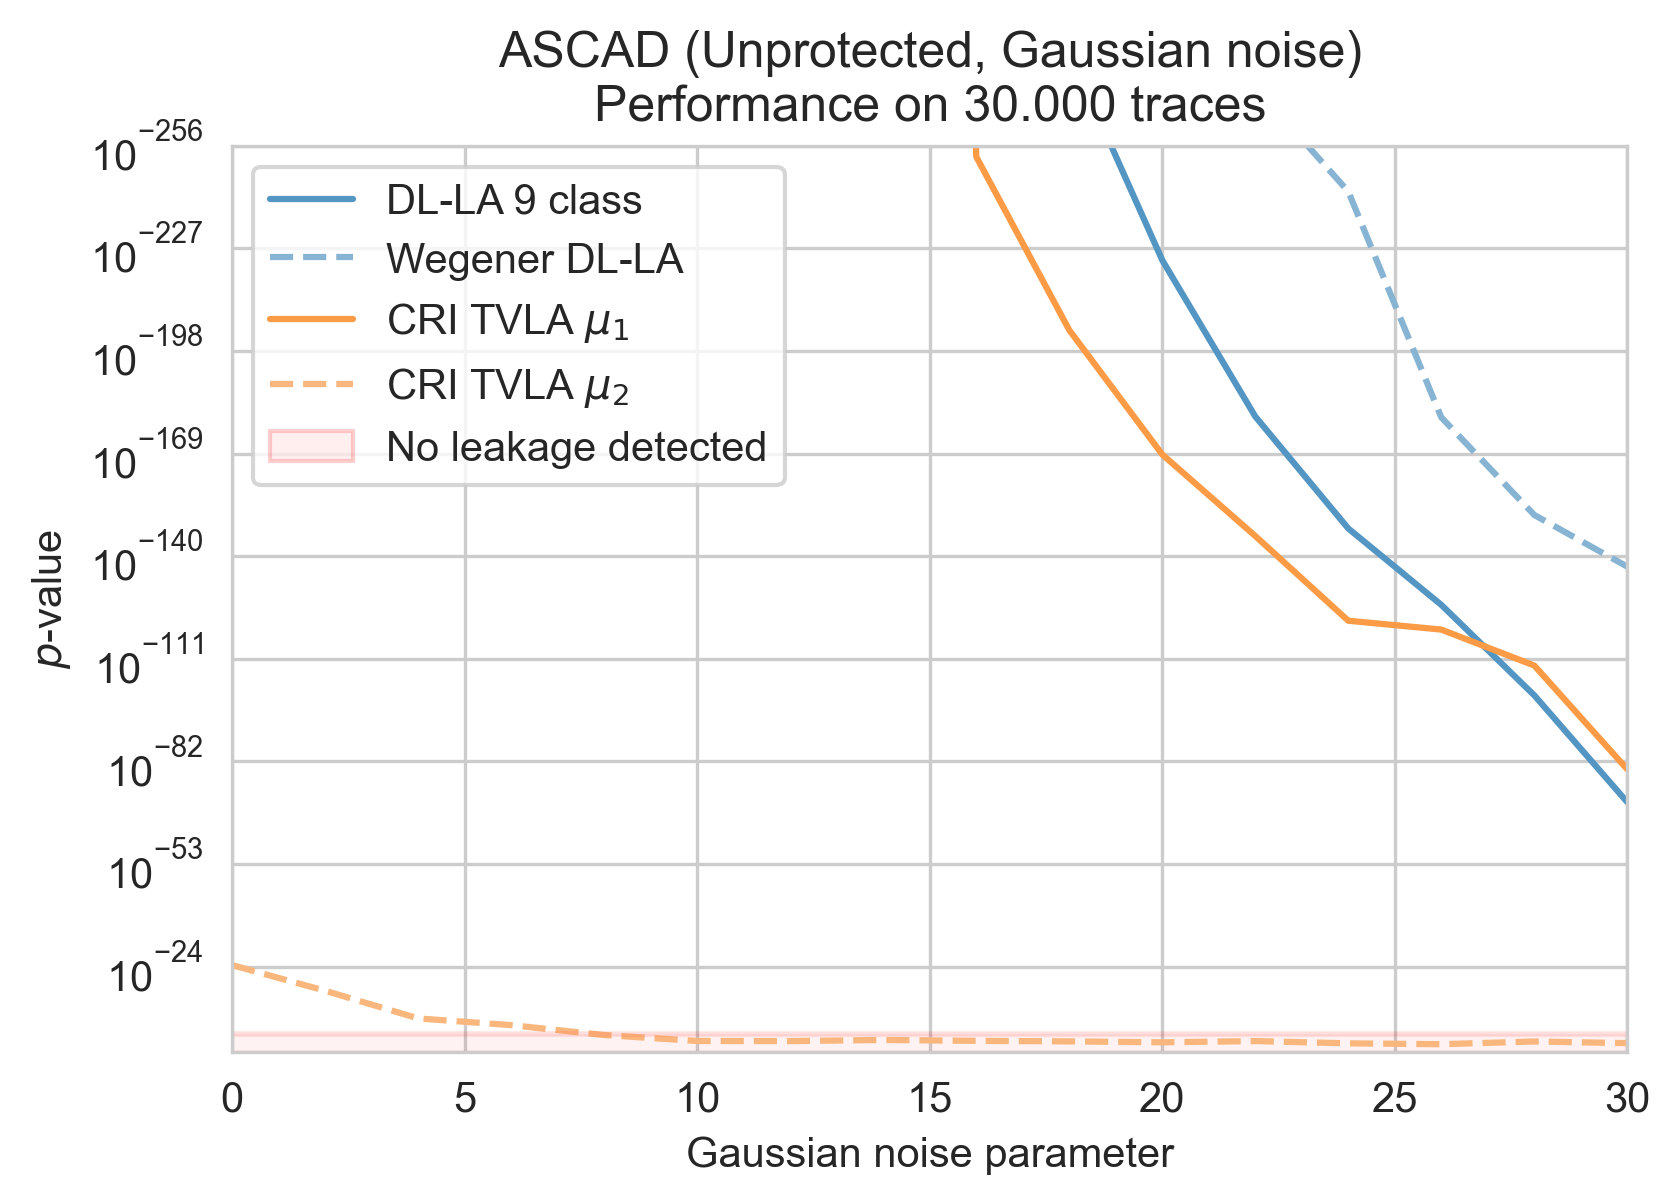

In [7]:
plot(Database.ascad_none, PollutionType.gauss, xlim=(0, 30), num_traces="30k")

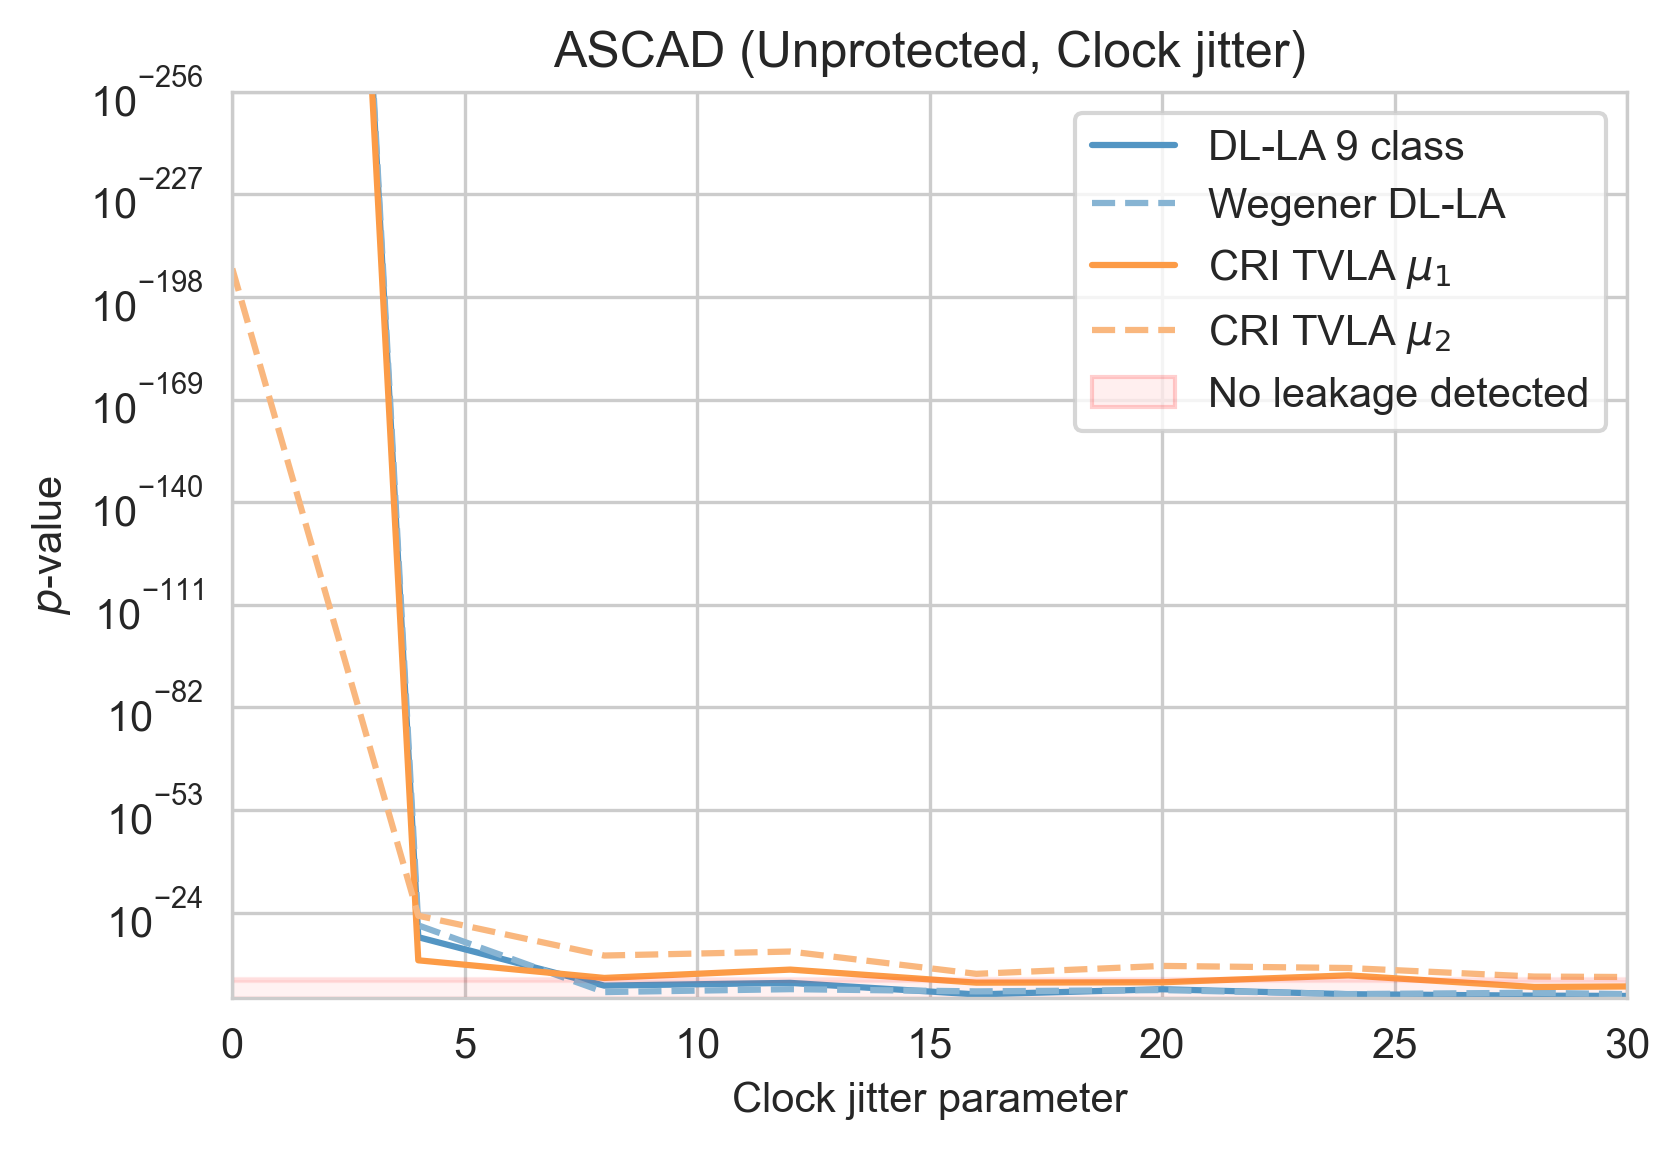

In [8]:
plot(Database.ascad_none, PollutionType.jitter, xlim=(0, 30))

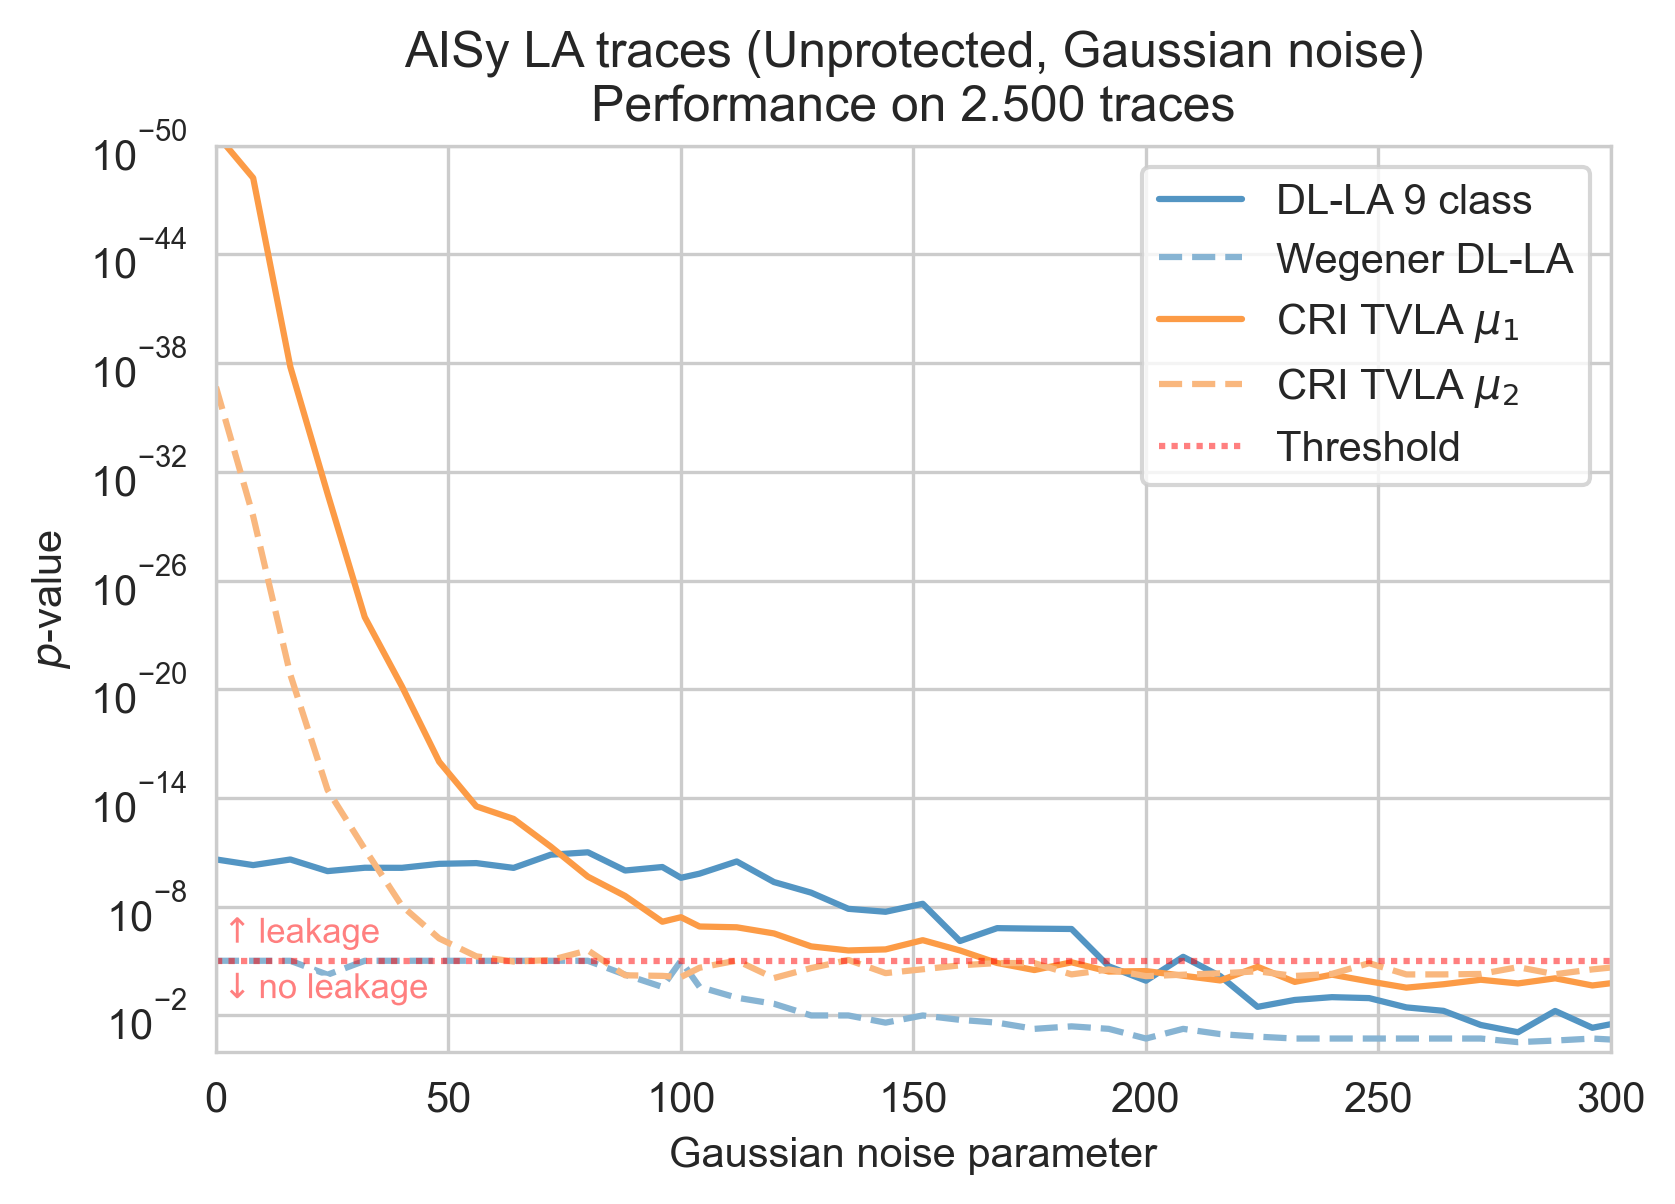

In [117]:
plot(Database.aisy, PollutionType.gauss, xlim=(0, 300), ylim=(1, 10 ** -50))